In [119]:
# Libraries import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
!pip install pycld2
import pycld2 as cld2


import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Importing Files from Google Drive

#!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [123]:
#2. Get the file
downloaded = drive.CreateFile({'id':"1f4BMP-chYE2PXiP0G4951tuHhwpgdRTt"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stockerbot-export.csv')

# 1) Explore dataset

In [124]:
#3. Read file as panda dataframe

data = pd.read_csv('stockerbot-export.csv')
print(data.shape)
print(data.columns)
#28k+ tweets in our database

(28572, 8)
Index(['id', 'text', 'timestamp', 'source', 'symbols', 'company_names', 'url',
       'verified'],
      dtype='object')


In [ ]:
data.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1.019700e+18,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1.019710e+18,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1.019710e+18,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1.019720e+18,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1.019720e+18,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


In [ ]:
data.describe(include='all')

,id,text,timestamp,source,symbols,company_names,url,verified
count,2.857200e+04,28572,28572,28572,28572,28572,22168,28572
unique,NaN,25973,27078,5900,453,461,18048,2
top,NaN,RT @MorganLBrennan: With #Helsinki2018 underwa...,Wed Jul 18 22:19:00 +0000 2018,bibeypost_stock,NFLX,Twenty-First Century Fox,http://binance.com/?ref=10078236,False
freq,NaN,69,7,1009,101,131,851,28208
mean,7.020380e+20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.386848e+21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,9.671090e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.018360e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.019230e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.019590e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(data.dtypes)
print('===========================')
print(data.isnull().sum())

id               float64
text              object
timestamp         object
source            object
symbols           object
company_names     object
url               object
verified            bool
dtype: object
id                  0
text                0
timestamp           0
source              0
symbols             0
company_names       0
url              6404
verified            0
dtype: int64


In [ ]:
#graph timestamp pour voir période données

data['Datetime'] = pd.to_datetime(data['timestamp'])

datatime = data.set_index('Datetime').groupby(pd.Grouper(freq='D'))['id'].count() #group tweets by day of publication

fig = px.line(datatime, x=datatime.index, y=datatime.values)
fig.update_layout(xaxis_title='Day',
                   yaxis_title='Number of tweets')
fig.show()

One tweet on February the 23th and the 28k+ others from July the 8th to the 19th.

In [ ]:
print('Number of duplicated tweets is : {}'.format(len(data[data.duplicated(subset=['text'])])))

Number of duplicated tweets is : 2599


In [ ]:
print('average number of characters =', data.text.apply(len).mean(), '| median =', data.text.apply(len).median())
#overall, short number of characters : they're Tweets

average number of characters = 108.9407811843763 | median = 114.0


In [ ]:
fig = px.histogram(data, x=data.text.apply(len), labels={'x':'Number of characters', 'y':'fréquence'})
fig.show()

In [ ]:
fig = px.bar(data, x=['False', 'True'], y=data.groupby('verified')['id'].count())
fig.update_layout(xaxis_title='Is_verified',
                   yaxis_title='Number of tweets')
fig.show()

# Most tweets come from non-verified persons

In [ ]:
importance_company = data.groupby(by='company_names')['id'].count()
top50 = importance_company.sort_values(ascending=False)[0:50]

fig = px.bar(top50, x= top50.index , y=top50.values)
fig.update_layout(yaxis_title='Number of tweets concerning')
fig.show()

# 2) Preprocessing of the text

## 2.1) Keep only english text

In [ ]:
text_list = data.text.to_list()

In [ ]:
# Fixing one tweet that raises an error because of bad characters

text_list[22439]

'$ERIC "ERIC looks ripe so doesÃ¢â\x82¬Â¦" on Yahoo! Finance message boards: https://t.co/5BFkwqacgQ'

In [ ]:
text_list[22439] = text_list[22439].replace('Ã¢â\x82¬Â¦','')

text_list[22439]

'$ERIC "ERIC looks ripe so does" on Yahoo! Finance message boards: https://t.co/5BFkwqacgQ'

In [ ]:
# Let's get the language of each tweet

language_lst = []


for txt in text_list:
  _, _, _, detected_language = cld2.detect(txt,  returnVectors=True)

  language_lst.append(detected_language[0][-1])

In [ ]:
data['detected_language'] = language_lst

data.head()

In [ ]:
data['detected_language'].value_counts()

en         24231
un          4122
es           112
ja            45
pt            13
de            10
xx-Qaai        7
da             4
fr             4
nl             3
ko             3
zh             2
tr             2
id             2
lv             1
ar             1
tl             1
it             1
sco            1
sr             1
ia             1
no             1
cs             1
pl             1
ru             1
sv             1
Name: detected_language, dtype: int64

In [ ]:
english_data = data.loc[data['detected_language'] == 'en']

In [ ]:
# Let's only keep unique tweets based on their text

unique_english_data = english_data.drop_duplicates(subset=['text'])

In [ ]:
# unique_english_data.to_csv('unique_english_tweets.csv')

## 2.2) Wordcloud

In [ ]:
# Let's now have a look at our tweets

tweet_list = unique_english_data.text.to_list()

In [ ]:
# First, we need to apply NLP techniques (like removing stopword and punctuation, URLs, etc)
# to transform our tweets se we can analyze them

# So let's create our preprocessing function

def preprocess(string):

    
    #Remove punctuation, hashtags and lower all characters
    words = nltk.word_tokenize(string)
    words = [word.lower().replace('#','') for word in words if word.isalnum()]
#     print(words)


    #Remove url

    words2 = [word for word in words if 'https' not in word]
    words3 = [word for word in words2 if 'http' not in word]
    
    
    #Remove stop words
    stop_words = set(stopwords.words('english'))
    words4 = [i for i in words3 if not i in stop_words]
#     print(words2)


    #Stemming
    # stemmer = PorterStemmer()
    # final = [stemmer.stem(word) for word in words2]
#     print(final)

    final = words4
    
    return final

In [ ]:
# Let's apply the function to our tweets
preprocessed_tweets = [preprocess(str(tweet)) for tweet in tweet_list]

preprocessed_tweets_concat = [" ".join(tweet) for tweet in preprocessed_tweets]

In [ ]:
# Here we create a string containing all the preprocessed tweets, to later create a beautiful word cloud

concat_tweets = ""

for tweet in preprocessed_tweets:
    concat_tweets = concat_tweets + " " + " ".join(tweet) 
    
concat_tweets = concat_tweets.lstrip()

In [ ]:
#2. Get the file
downloaded = drive.CreateFile({'id':"1FZdBc7OjPDEehTGWxQKBliwCtDmrWrCC"})   # replace the id with id of file you want to access
downloaded.GetContentFile('twitter_logo.png')

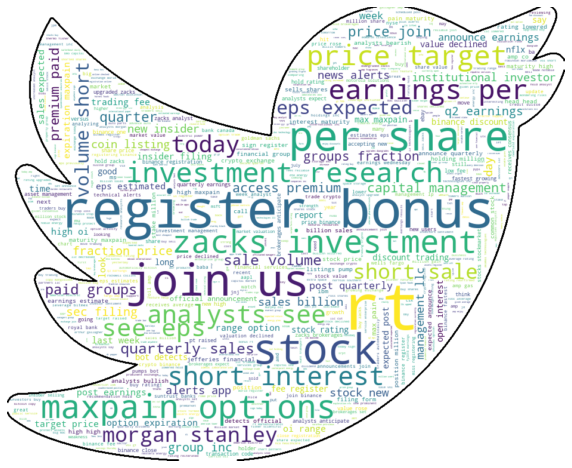

In [ ]:
# And here we generate our word cloud, on a Twitter logo background!

movie_mask = np.array(Image.open("twitter_logo.png"))

wc = WordCloud(background_color="white", max_words=1000, mask=movie_mask, contour_width=3)

wc.generate(concat_tweets)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 3) Labelizing 

## 3.1) Import labelized tweets

In [ ]:
# After labelizing our tweets, let's reimport them

downloaded = drive.CreateFile({'id':"1NBbr21wjNSHxGh-Rk_NpG5yPc4x0vHGP"})
downloaded.GetContentFile('Tweets_Labelization.xlsx')

In [ ]:
xlsx = pd.ExcelFile('Tweets_Labelization.xlsx')
tweets = pd.read_excel(xlsx, 'Final_Export')

In [ ]:
tweets.head(5)

,text,timestamp,source,symbols,company_names,url,verified,Datetime,detected_language,sentiment,sentiment_text
0,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True,2018-07-18 22:22:47+00:00,en,0,negative
1,U.S. proposes expedited appeal in fight with A...,Wed Jul 18 23:18:36 +0000 2018,Reuters,TWX,Time Warner,https://reut.rs/2O1Ao46,True,2018-07-18 23:18:36+00:00,en,0,negative
2,Alcoa cuts adjusted EBITDA forecast citing tar...,Wed Jul 18 23:24:09 +0000 2018,Reuters,HPQ,HP,https://reut.rs/2NZoM1r,True,2018-07-18 23:24:09+00:00,en,0,negative
3,Customers urge boycott of MGM Resorts after th...,Wed Jul 18 23:26:33 +0000 2018,business,MGM,MGM Resorts,https://twitter.com/i/web/status/1019725139905...,True,2018-07-18 23:26:33+00:00,en,0,negative
4,White House struggles to contain fallout from ...,Wed Jul 18 23:45:49 +0000 2018,Reuters,UDR,UDR,https://reut.rs/2NrEv8t,True,2018-07-18 23:45:49+00:00,en,0,negative


In [ ]:
print('text =', tweets.text.iloc[0], '| airline_sentiment =', tweets.sentiment_text.iloc[0])

text = The price of lumber $LB_F is down 22% since hitting its YTD highs. The Macy's $M turnaround is still happening.… https://t.co/XnKsV4De39 | airline_sentiment = negative


## 3.2) What's in our labelized dataset

In [ ]:
tweets.groupby('sentiment_text')['text'].count()

sentiment_text
negative    1919
neutral     1048
positive    3602
Name: text, dtype: int64

In [ ]:
fig = px.bar(tweets, x=['negative', 'neutral', 'positive'], y=tweets.groupby('sentiment_text')['text'].count())
# Set the visibility ON
fig.update_yaxes(title='Number of tweets', visible=True, showticklabels=False)
fig.show()

In [ ]:
importance_labeled_company = tweets.groupby(by='company_names')['text'].count()
top50_label = importance_labeled_company.sort_values(ascending=False)[0:50]

fig = px.bar(top50_label, x= top50_label.index , y=top50_label.values)
fig.update_layout(yaxis_title='Number of tweets concerning')
fig.show()

In [ ]:
tweets['Datetime'] = pd.to_datetime(tweets['timestamp'])

In [ ]:
datatime_label = tweets.set_index('Datetime').groupby(pd.Grouper(freq='D'))['text'].count() #group tweets by day of publication

In [ ]:
fig = px.line(datatime_label, x=datatime_label.index, y=datatime_label.values)
fig.update_layout(xaxis_title='Day',
                   yaxis_title='Number of tweets')
fig.show()

# 4) Baseline model (Random Forest)

## 4.1) Preprocessing and splits

In [ ]:
# Let's try a first - relatively low complexity - model 

In [ ]:
X = tweets.loc[:, "text"]
print(X)
print(X.shape)

0       The price of lumber $LB_F is down 22% since hi...
1       U.S. proposes expedited appeal in fight with A...
2       Alcoa cuts adjusted EBITDA forecast citing tar...
3       Customers urge boycott of MGM Resorts after th...
4       White House struggles to contain fallout from ...
                              ...                        
6564    Walmart hired a former Humana exec to lead its...
6565    $CMA $CMA.WS Comerica (CMA) Q2 Earnings Improv...
6566    $NDAQ Market Snapshot: U.S. stocks rally after...
6567    Bitcoin on a tear overnight +10%  Blockchain s...
6568    Big bullish unusual option activity detected: ...
Name: text, Length: 6569, dtype: object
(6569,)


In [ ]:
y = tweets.sentiment
print(y)
print(y.shape)

0       0
1       0
2       0
3       0
4       0
       ..
6564    2
6565    2
6566    2
6567    2
6568    2
Name: sentiment, Length: 6569, dtype: int64
(6569,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_rf, X_devtest_rf, y_train_rf, y_devtest_rf = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train_rf)
print(y_train_rf)

3555    How Analysts Feel About Kellogg Company $K? - ...
5707    Free chrome extension to hide tweets that over...
4351    Today's #metronome Daily Supply Lot: 2880 $MET...
2218    Were Analysts Bullish National Oilwell Varco I...
5151    Market is watchful of the trade war with finan...
                              ...                        
3772    FirstEnergy declares $0.36 dividend https://t....
5191    Is Exxon Mobil Corporation $XOM a Buy? The Sto...
5226    American Airlines Group $AAL Price Target Cut ...
5390    Never used your app and pickup service before ...
860     $AEE high OI range is 60.00 to 60.00 for optio...
Name: text, Length: 3941, dtype: object
3555    1
5707    2
4351    2
2218    2
5151    2
       ..
3772    1
5191    2
5226    2
5390    2
860     1
Name: sentiment, Length: 3941, dtype: int64


In [ ]:
X_dev_rf, X_test_rf, y_dev_rf, y_test_rf = train_test_split(X_devtest_rf, y_devtest_rf, test_size=0.5, random_state=42)
print(X_dev_rf)
print(y_dev_rf)

231     Zacks Investment Research Downgrades Stanley B...
1454    Zacks Investment Research Upgrades Torchmark $...
890     $PNR open interest for maturity 07/20/2018. Hi...
4125    @LIBRA14885 Not that big a deal??????.......th...
3412    Pfizer and Lilly's tanezumab successful in lat...
                              ...                        
344     As Harris Corp Del $HRS Share Price Declined B...
2387    Honeywell Intl INC $HON Market Valuation Decli...
5209    Comerica $CMA Stock Rating Upgraded by Zacks I...
6307    Buy $QSP 1000-1100  Stop loss: 850  Sell: 1300...
1261    American Electric Power Company Inc. $AEP EPS ...
Name: text, Length: 1314, dtype: object
231     0
1454    2
890     1
4125    2
3412    1
       ..
344     0
2387    0
5209    2
6307    2
1261    1
Name: sentiment, Length: 1314, dtype: int64


## 4.2) Training and results

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train_rf)
X_train_cv.shape

(3941, 10141)

In [ ]:
X_dev_cv = cv.transform(X_dev_rf)
X_dev_cv.shape

(1314, 10141)

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train_rf)
y_train_lb = lb_trained.transform(y_train_rf)
y_dev_lb = lb_trained.transform(y_dev_rf)
print(y_train_lb.shape, y_dev_lb.shape)

(3941, 3) (1314, 3)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval_rf(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


              precision    recall  f1-score   support

           0       0.90      0.85      0.88       415
           1       0.86      0.67      0.75       218
           2       0.86      0.96      0.91       681

    accuracy                           0.88      1314
   macro avg       0.88      0.82      0.85      1314
weighted avg       0.88      0.88      0.87      1314



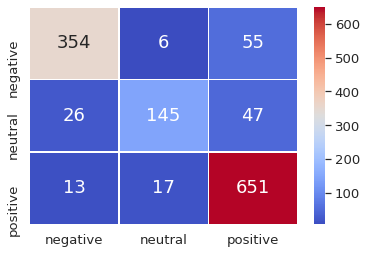

negative 0.8933259176863181
neutral 0.8220761066095224
positive 0.8974048479027915


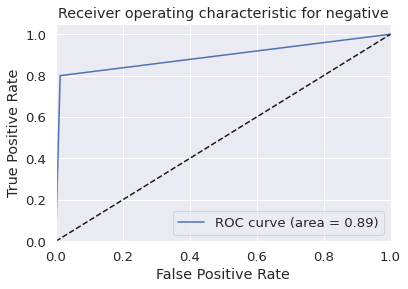

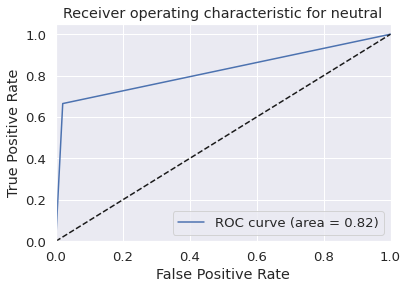

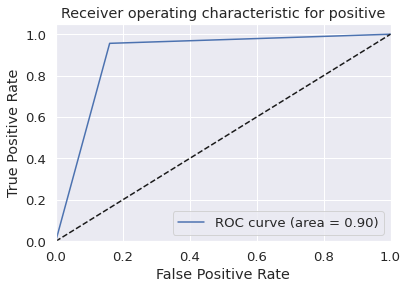

In [ ]:
y_pred_rfc = rfc.predict(X_dev_cv)
show_eval_rf(y_dev_lb, y_pred_rfc, lb_trained, rfc )

# 5) BERT

In [ ]:
!pip install transformers
#!pip install torchtext==0.8.0    

     |████████████████████████████████| 2.1MB 18.3MB/s 
     |████████████████████████████████| 901kB 47.5MB/s 
     |████████████████████████████████| 3.3MB 49.5MB/s 


In [ ]:
tweets_list = tweets.text.to_list()

## 5.1) BERT (3 labels)

### 5.1.1) Preprocessing

In [125]:
import re

cleaned_tweets = []

for tweet in tweets_list:

  temp = ' '.join(re.sub("(@[A-Za-z0–9]+)|(\w+:\/\/\S+)"," ",tweet).split())
  temp2 = re.sub(r'\$\w*', '', tweet)
  clean_tweet = re.sub('http[s]?://\S+', '', temp2).strip()

  cleaned_tweets.append(clean_tweet)

In [126]:
tweets['cleaned_text'] = cleaned_tweets

In [127]:
tweets_bert = tweets[['cleaned_text','sentiment']]
tweets_bert = tweets_bert.rename(columns={"cleaned_text": "text"})

tweets_bert

,text,sentiment
0,The price of lumber is down 22% since hitting...,0
1,U.S. proposes expedited appeal in fight with A...,0
2,Alcoa cuts adjusted EBITDA forecast citing tar...,0
3,Customers urge boycott of MGM Resorts after th...,0
4,White House struggles to contain fallout from ...,0
...,...,...
6564,Walmart hired a former Humana exec to lead its...,2
6565,.WS Comerica (CMA) Q2 Earnings Improve Y/Y Exp...,2
6566,Market Snapshot: U.S. stocks rally after earni...,2
6567,Bitcoin on a tear overnight +10% Blockchain s...,2


### 5.1.2) Quantitative analysis

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [129]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [130]:
train_test_ratio = 0.75
train_valid_ratio = 0.75
# destination_folder = '/content/gdrive/My Drive/NLP4ML/Data/'
# source_folder = '/content/gdrive/My Drive/NLP4ML/Model/'


source_folder = '/content/gdrive/My Drive/NLP4ML/Data/'
destination_folder = '/content/gdrive/My Drive/NLP4ML/Model/'

In [131]:
first_n_words = 128

def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

# Trim text and titletext to first_n_words
tweets_bert['text'] = tweets_bert['text'].apply(trim_string) 
#tweets_bert.drop(columns=['texet'])

In [132]:
tweets_bert

,text,sentiment
0,The price of lumber is down 22% since hitting ...,0
1,U.S. proposes expedited appeal in fight with A...,0
2,Alcoa cuts adjusted EBITDA forecast citing tar...,0
3,Customers urge boycott of MGM Resorts after th...,0
4,White House struggles to contain fallout from ...,0
...,...,...
6564,Walmart hired a former Humana exec to lead its...,2
6565,.WS Comerica (CMA) Q2 Earnings Improve Y/Y Exp...,2
6566,Market Snapshot: U.S. stocks rally after earni...,2
6567,Bitcoin on a tear overnight +10% Blockchain st...,2


In [133]:
# Split according to label
df_negative = tweets_bert[tweets_bert['sentiment'] == 0]
df_neutral = tweets_bert[tweets_bert['sentiment'] == 1]
df_positive = tweets_bert[tweets_bert['sentiment'] == 2]

# Train-test split
df_negative_full_train, df_negative_test = train_test_split(df_negative, train_size = train_test_ratio, random_state = 1)
df_neutral_full_train, df_neutral_test = train_test_split(df_neutral, train_size = train_test_ratio, random_state = 1)
df_positive_full_train, df_positive_test = train_test_split(df_positive, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_negative_train, df_negative_valid = train_test_split(df_negative_full_train, train_size = train_valid_ratio, random_state = 1)
df_neutral_train, df_neutral_valid = train_test_split(df_neutral_full_train, train_size = train_valid_ratio, random_state = 1)
df_positive_train, df_positive_valid = train_test_split(df_positive_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_negative_train, df_neutral_train, df_positive_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_negative_valid, df_neutral_valid, df_positive_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_negative_test, df_neutral_test, df_positive_test], ignore_index=True, sort=False)

In [134]:
df_negative

,text,sentiment
0,The price of lumber is down 22% since hitting ...,0
1,U.S. proposes expedited appeal in fight with A...,0
2,Alcoa cuts adjusted EBITDA forecast citing tar...,0
3,Customers urge boycott of MGM Resorts after th...,0
4,White House struggles to contain fallout from ...,0
...,...,...
3357,Short sale volume(not short interest) for on 2...,0
3358,The Tell: Fund managers say trade spat is the ...,0
3359,Apartment Investment and Management Company Co...,0
3360,what a disappointing afternoon in . Thought sh...,0


In [135]:
df_neutral

,text,sentiment
828,VIDEO: “I was in my office. I was minding my o...,1
829,How satellites avoid attacks and space junk wh...,1
830,Don’t miss my convo with one of my favorite th...,1
831,U.S. intelligence documents on Nelson Mandela ...,1
832,Senate wants emergency alerts to go out throug...,1
...,...,...
3794,Northrop Grumman CEO to Step Down at Year's End,1
3795,RT @insidermonkey: #HedgeFund and #InsiderTrad...,1
3796,Gap Inc Expected to Announce Quarterly Sales o...,1
3797,Zacks: Analysts Expect Gap Inc Will Post Earni...,1


In [136]:
df_positive

,text,sentiment
1439,Who says the American Dream is dead?,2
1440,Barry Silbert is extremely optimistic on bitco...,2
1441,.@RealMoney's David Butler's favorite FANG sto...,2
1442,Hedge fund manager Marc Larsy says bitcoin is ...,2
1443,Roger Federer's Uniqlo deal makes him one of t...,2
...,...,...
6564,Walmart hired a former Humana exec to lead its...,2
6565,.WS Comerica (CMA) Q2 Earnings Improve Y/Y Exp...,2
6566,Market Snapshot: U.S. stocks rally after earni...,2
6567,Bitcoin on a tear overnight +10% Blockchain st...,2


In [137]:
# Write preprocessed data
df_train.to_csv(source_folder + 'train.csv', index=False)
df_valid.to_csv(source_folder + 'valid.csv', index=False)
df_test.to_csv(source_folder + 'test.csv', index=False)

In [138]:
print('Shape of train:', df_train.shape)
print('Shape of validation:', df_valid.shape)
print('Shape of test:', df_test.shape)

Shape of train: (3693, 2)
Shape of validation: (1233, 2)
Shape of test: (1643, 2)


In [139]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [140]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('sentiment', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path= source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text), 
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [141]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels=3)

    def forward(self, text, sentiment):
        loss, text_fea = self.encoder(text, labels=sentiment)[:2]

        return loss, text_fea

In [142]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [144]:
# Training Function

def train(model,
          optimizer,
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [115/1155], Train Loss: 1.0455, Valid Loss: 0.9939
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [1/5], Step [230/1155], Train Loss: 1.0126, Valid Loss: 0.9228
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [2/5], Step [345/1155], Train Loss: 0.9328, Valid Loss: 0.5958
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [2/5], Step [460/1155], Train Loss: 0.5662, Valid Loss: 0.4980
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [3/5], Step [575/1155], Train Loss: 0.3966, Valid Loss: 0.3798
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/

Model loaded from <== /content/gdrive/My Drive/NLP4ML/Model//metrics.pt


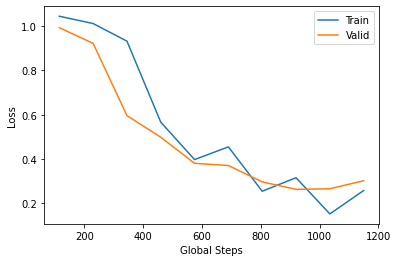

In [145]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [146]:
# Evaluation Function

y_pred = []
y_true = []

def evaluate(model, test_loader):

    model.eval()
    with torch.no_grad():
        for (text,labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)    
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text,labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())

    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[2,1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[2,1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/NLP4ML/Model//model.pt
Classification Report:
              precision    recall  f1-score   support

           2     0.9021    0.9412    0.9212       901
           1     0.8144    0.8206    0.8175       262
           0     0.9681    0.8854    0.9249       480

    accuracy                         0.9057      1643
   macro avg     0.8949    0.8824    0.8879      1643
weighted avg     0.9074    0.9057    0.9058      1643



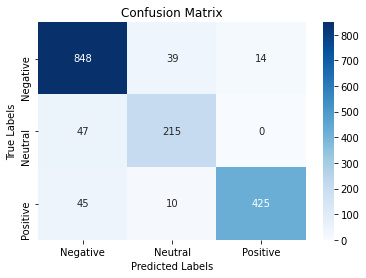

In [147]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

### 5.2.3) Qualitative analysis

In [148]:
results = df_test.copy()

results['prediction'] = y_pred

In [153]:
results[results['sentiment'] != results['prediction']].sample(5)

,text,sentiment,prediction
290,Customers urge boycott of MGM Resorts after th...,0,2
337,Tuesday's Top Analyst Upgrades and Downgrades ...,0,2
721,Thanks for @jonnajarian I love your #60SEC Jul...,1,2
561,Get the latest news and updates for automatica...,1,2
315,open interest for maturity 07/20/2018. High pu...,0,1


In [161]:
results[(results['sentiment'] == 0) & (results['prediction'] == 1)]

,text,sentiment,prediction
26,Lincoln National Cut to Hold at Zacks Investme...,0,1
75,open interest for maturity 07/20/2018. High pu...,0,1
116,open interest for maturity 07/20/2018. High pu...,0,1
193,open interest for maturity 07/20/2018. High pu...,0,1
198,open interest for maturity 07/20/2018. High pu...,0,1
236,open interest for maturity 07/20/2018. High pu...,0,1
296,open interest for maturity 07/20/2018. High pu...,0,1
305,open interest for maturity 07/20/2018. High pu...,0,1
315,open interest for maturity 07/20/2018. High pu...,0,1
452,open interest for maturity 07/20/2018. High pu...,0,1


## 5.2) BERT : 2 labels (POSITIVE & NEGATIVE)

### 5.2.1) Quantitative analysis

In [162]:
!pip install transformers
#!pip install torchtext==0.8.0    

In [163]:
tweets_list = tweets.text.to_list()

In [165]:
import re

cleaned_tweets = []

for tweet in tweets_list:

  temp = ' '.join(re.sub("(@[A-Za-z0–9]+)|(\w+:\/\/\S+)"," ",tweet).split())
  temp2 = re.sub(r'\$\w*', '', tweet)
  clean_tweet = re.sub('http[s]?://\S+', '', temp2).strip()

  cleaned_tweets.append(clean_tweet)

In [166]:
tweets['cleaned_text'] = cleaned_tweets

In [167]:
tweets_bert = tweets[['cleaned_text','sentiment']]
tweets_bert = tweets_bert.rename(columns={"cleaned_text": "text"})

tweets_bert

,text,sentiment
0,The price of lumber is down 22% since hitting...,0
1,U.S. proposes expedited appeal in fight with A...,0
2,Alcoa cuts adjusted EBITDA forecast citing tar...,0
3,Customers urge boycott of MGM Resorts after th...,0
4,White House struggles to contain fallout from ...,0
...,...,...
6564,Walmart hired a former Humana exec to lead its...,2
6565,.WS Comerica (CMA) Q2 Earnings Improve Y/Y Exp...,2
6566,Market Snapshot: U.S. stocks rally after earni...,2
6567,Bitcoin on a tear overnight +10% Blockchain s...,2


In [168]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [169]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [170]:
train_test_ratio = 0.75
train_valid_ratio = 0.75
# destination_folder = '/content/gdrive/My Drive/NLP4ML/Data/'
# source_folder = '/content/gdrive/My Drive/NLP4ML/Model/'


source_folder = '/content/gdrive/My Drive/NLP4ML/Data/'
destination_folder = '/content/gdrive/My Drive/NLP4ML/Model/'

In [171]:
first_n_words = 128

def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

# Trim text and titletext to first_n_words
tweets_bert['text'] = tweets_bert['text'].apply(trim_string) 
#tweets_bert.drop(columns=['texet'])

In [172]:
tweets_bert.shape

(6569, 2)

In [173]:
tweets_bert = tweets_bert[tweets_bert['sentiment'] != 1]
tweets_bert.shape

(5521, 2)

In [174]:
# Split according to label
df_negative = tweets_bert[tweets_bert['sentiment'] == 0]
df_positive = tweets_bert[tweets_bert['sentiment'] == 2]

In [175]:
#Giving the label 1 to positive tweets 
df_positive['sentiment'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
# Train-test split
df_negative_full_train, df_negative_test = train_test_split(df_negative, train_size = train_test_ratio, random_state = 1)
df_positive_full_train, df_positive_test = train_test_split(df_positive, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_negative_train, df_negative_valid = train_test_split(df_negative_full_train, train_size = train_valid_ratio, random_state = 1)
df_positive_train, df_positive_valid = train_test_split(df_positive_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_negative_train, df_positive_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_negative_valid, df_positive_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_negative_test, df_positive_test], ignore_index=True, sort=False)

In [177]:
df_negative

,text,sentiment
0,The price of lumber is down 22% since hitting ...,0
1,U.S. proposes expedited appeal in fight with A...,0
2,Alcoa cuts adjusted EBITDA forecast citing tar...,0
3,Customers urge boycott of MGM Resorts after th...,0
4,White House struggles to contain fallout from ...,0
...,...,...
3357,Short sale volume(not short interest) for on 2...,0
3358,The Tell: Fund managers say trade spat is the ...,0
3359,Apartment Investment and Management Company Co...,0
3360,what a disappointing afternoon in . Thought sh...,0


In [178]:
df_positive

,text,sentiment
1439,Who says the American Dream is dead?,1
1440,Barry Silbert is extremely optimistic on bitco...,1
1441,.@RealMoney's David Butler's favorite FANG sto...,1
1442,Hedge fund manager Marc Larsy says bitcoin is ...,1
1443,Roger Federer's Uniqlo deal makes him one of t...,1
...,...,...
6564,Walmart hired a former Humana exec to lead its...,1
6565,.WS Comerica (CMA) Q2 Earnings Improve Y/Y Exp...,1
6566,Market Snapshot: U.S. stocks rally after earni...,1
6567,Bitcoin on a tear overnight +10% Blockchain st...,1


In [179]:
# Write preprocessed data
df_train.to_csv(source_folder + 'train.csv', index=False)
df_valid.to_csv(source_folder + 'valid.csv', index=False)
df_test.to_csv(source_folder + 'test.csv', index=False)

In [180]:
print('Shape of train:', df_train.shape)
print('Shape of validation:', df_valid.shape)
print('Shape of test:', df_test.shape)

Shape of train: (3104, 2)
Shape of validation: (1036, 2)
Shape of test: (1381, 2)


In [181]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [182]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('sentiment', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path= source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text), #Put 16 to try instead of 6 choosen to prevent bug
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [183]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels=2)

    def forward(self, text, sentiment):
        loss, text_fea = self.encoder(text, labels=sentiment)[:2]

        return loss, text_fea

In [184]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [185]:
# Training Function

def train(model,
          optimizer,
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [97/970], Train Loss: 0.7034, Valid Loss: 0.6441
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [1/5], Step [194/970], Train Loss: 0.5504, Valid Loss: 0.4341
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [2/5], Step [291/970], Train Loss: 0.3195, Valid Loss: 0.3098
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [2/5], Step [388/970], Train Loss: 0.3576, Valid Loss: 0.2414
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//metrics.pt
Epoch [3/5], Step [485/970], Train Loss: 0.1596, Valid Loss: 0.1618
Model saved to ==> /content/gdrive/My Drive/NLP4ML/Model//model.pt
Model saved to ==> /content/gdrive/My Drive/NLP4ML

Model loaded from <== /content/gdrive/My Drive/NLP4ML/Model//metrics.pt


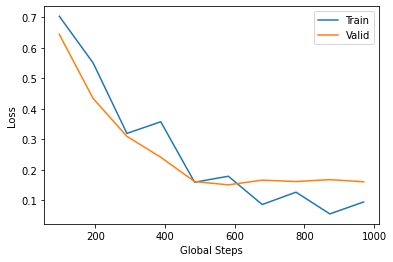

In [186]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [190]:
# Evaluation Function
y_pred = []
y_true = []

def evaluate_2label(model, test_loader):

    model.eval()
    with torch.no_grad():
        for (text,labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)    
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text,labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())

    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/gdrive/My Drive/NLP4ML/Model//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9537    0.9834    0.9683       901
           0     0.9668    0.9104    0.9378       480

    accuracy                         0.9580      1381
   macro avg     0.9603    0.9469    0.9530      1381
weighted avg     0.9583    0.9580    0.9577      1381



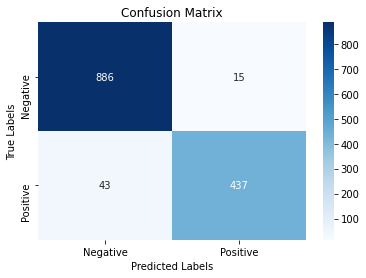

In [191]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate_2label(best_model, test_iter)

### 5.2.2) Qualitative analysis

In [192]:
results = df_test.copy()

results['prediction'] = y_pred

In [195]:
results[results['sentiment'] != results['prediction']].sample(5)

,text,sentiment,prediction
1018,Autodesk Inc. Option Order Flow Sentiment has ...,1,0
261,chatter data breach of HIV results. Chatter wa...,0,1
246,Parallax Volatility Advisers LP Position in In...,0,1
1274,above recent highs out of small flag starting ...,1,0
269,@ReformedBroker This is why cannot justify pay...,0,1


In [194]:
results[(results['sentiment'] == 0) & (results['prediction'] == 1)]

,text,sentiment,prediction
6,Agilent Technologies Inc 's Stock Is Sell Afte...,0,1
15,CargoX plunges -3.95% on July 16-17 -,0,1
18,Arbiter Partners Capital Management LLC Mainta...,0,1
26,Lincoln National Cut to Hold at Zacks Investme...,0,1
42,earnings move 0.8% vs an expected ±3.5% move,0,1
54,Only losing / red swing currently is my 65 C l...,0,1
79,The Tell: Fund managers say trade spat is the ...,0,1
80,I'm not a financial advisor I'm a twitter robo...,0,1
101,is now a #CloudComputing king,0,1
105,Wednesday's Top Analyst Upgrades and Downgrade...,0,1


In [196]:
results[(results['sentiment'] == 1) & (results['prediction'] == 0)]

,text,sentiment,prediction
508,Aon Plc Shares Declined While Mawer Investment...,1,0
680,Altria Group Inc. (MO) stock price is -5.36% d...,1,0
685,RT @IcemanTrading: Raised to .10 at Piper Rais...,1,0
721,07/13/2018 Morning Brief: #Option Activity - #...,1,0
765,Kennametal Holder Royal Bank Of Canada Has Rai...,1,0
1018,Autodesk Inc. Option Order Flow Sentiment has ...,1,0
1070,Brookside Capital Management LLC Has Lowered C...,1,0
1159,Raised to .10 at Piper Raised to at BofA Lower...,1,0
1174,Benzinga's Top Upgrades Downgrades For July 16...,1,0
1209,Kinross Gold Corp. Market Value Declined While...,1,0
